In [1]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [3]:
numpy.set_printoptions(linewidth = 200)

qubits = 5

# # should be "GHZ", "cascade", "dense", or "clustered"
# circuit_type = "GHZ"
# layers = 1 # number of gate layers

# qubits = 6 # number of qubits
# frag_num = 2 # number of fragments

simulation_backend = "qasm_simulator"

seed = 0
print_circuits = True

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [5]:
device = provider.get_backend('ibmq_guadalupe')
device

<IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [6]:
noisy_simulator = provider.get_backend('ibmq_qasm_simulator')

In [7]:
front_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_front.qasm")

In [8]:
mid_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_mid.qasm")

In [9]:
end_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_end.qasm")

In [10]:
orign_circuit = front_layer + mid_layer + end_layer

In [11]:
#checking circuit

In [12]:
def apply_checking_circuit(qc, ctrl_bits, ancilla_bits, side = None):
    if len(ctrl_bits) != len(ancilla_bits):
        print("Size mismatch")
        return None
    if side == 'front':
        for i in ancilla_bits:
            qc.h(i)
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
    elif side == 'end':
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
        for i in ancilla_bits:
            qc.h(i)
    else:
        print("Side undefined")

In [13]:
circuit = front_layer.copy()

In [14]:
apply_checking_circuit(circuit, [4], [5], side = 'front')
circuit += mid_layer
apply_checking_circuit(circuit, [4], [5], side = 'end')
circuit += end_layer

In [15]:
circuit.draw()

┌────────────┐   ┌────────────┐                             »
q_0: ─┤ RY(-4.751) ├─■─┤ RY(4.6739) ├─────────────────────────────»
      ├────────────┤ │ └────────────┘┌─────────────┐              »
q_1: ─┤ RY(3.1415) ├─■───────■───────┤ RY(-3.1415) ├──────────────»
     ┌┴────────────┤         │       └─────────────┘┌────────────┐»
q_2: ┤ RY(-3.8492) ├─────────■──────────────■───────┤ RY(0.7076) ├»
     ├─────────────┤                        │       └────────────┘»
q_3: ┤ RY(-3.1416) ├────────────────────────■─────────────■───────»
     ├─────────────┤                                      │       »
q_4: ┤ RY(-6.8335) ├─■────────────────────────────────────■───────»
     └────┬───┬────┘ │                                            »
q_5: ─────┤ H ├──────■────────────────────────────────────────────»
          └───┘                                                   »
q_6: ─────────────────────────────────────────────────────────────»
                                                                  »
q_7: ─────────────────────────────────────────────────────────────»
                                                                  »
q_8: ─────────────────────────────────────────────────────────────»
                                                                  »
q_9: ─────────────────────────────────────────────────────────────»
                                                                  »
«                                  
«q_0: ─────────────────────────────
«                                  
«q_1: ─────────────────────────────
«                                  
«q_2: ─────────────────────────────
«     ┌────────────┐               
«q_3: ┤ RY(3.1415) ├───────────────
«     └────────────┘┌─────────────┐
«q_4: ──────■───────┤ RY(-3.6921) ├
«           │       └────┬───┬────┘
«q_5: ──────■────────────┤ H ├─────
«                        └───┘     
«q_6: ─────────────────────────────
«                                  
«q_7: ─────────────────────────────
«                                  
«q_8: ─────────────────────────────
«                                  
«q_9: ─────────────────────────────
«

In [16]:
trans_qc = transpile(circuit, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols


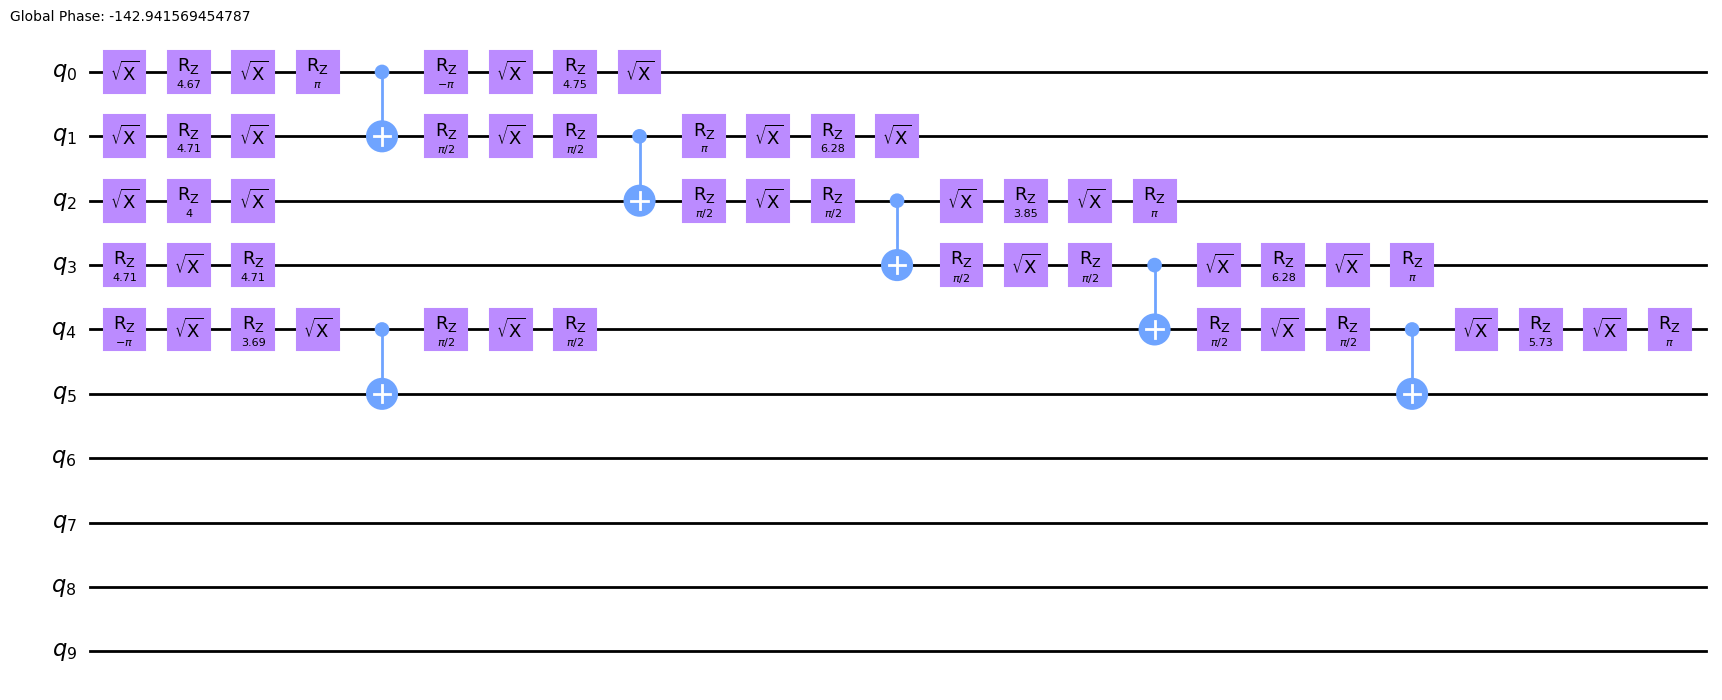

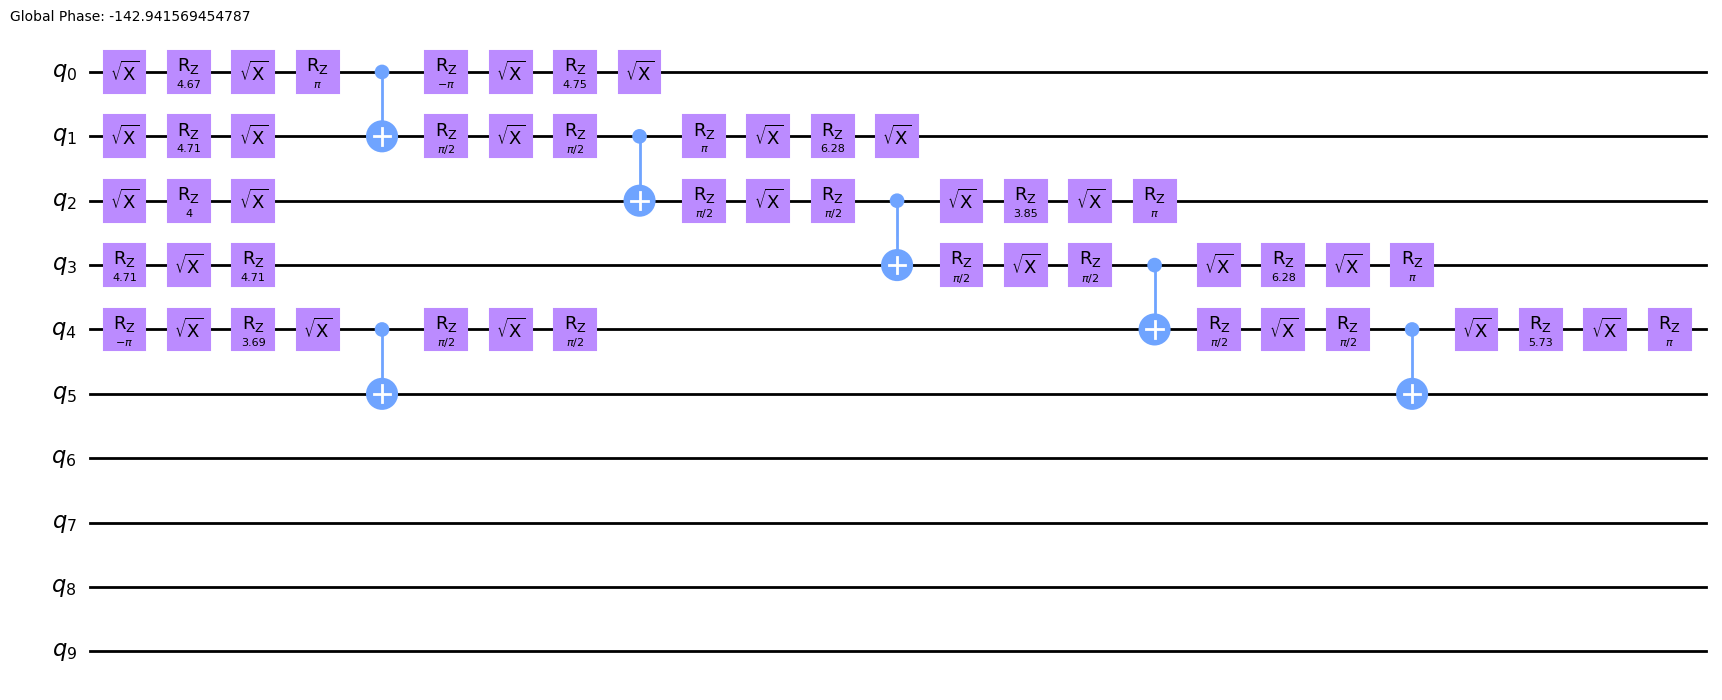

In [17]:
trans_qc.draw(output = 'mpl')

In [18]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device, gate_error = False, thermal_relaxation= False)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]), ('measure', [13]), ('measure', [14]), ('measure', [15])]


In [19]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [20]:
# p_gate1 = 0.4
# error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

In [21]:
# noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

In [22]:
circuit = trans_qc

In [23]:
cuts = []
# for i in range(0, 5):
#     if i == 0:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 6)]
#     elif i == 3:
#         cut = [(circuit.qubits[i], 4),(circuit.qubits[i], 12)]
#     elif i == qubits-1:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 12)]
#     else:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 13)]
#     cuts += cut
cuts = [(circuit.qubits[4], 5),(circuit.qubits[4], 12)]

In [24]:
print(cuts)

[(Qubit(QuantumRegister(10, 'q'), 4), 5), (Qubit(QuantumRegister(10, 'q'), 4), 12)]


In [25]:
fragments, wire_path_map = circuit_cutter.cut_circuit(circuit, cuts)

unused qubits: [Qubit(QuantumRegister(10, 'q'), 6), Qubit(QuantumRegister(10, 'q'), 7), Qubit(QuantumRegister(10, 'q'), 8), Qubit(QuantumRegister(10, 'q'), 9)]


In [26]:
print(wire_path_map)

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 3)),), Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 4)),), Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 4): ((1, Qubit(QuantumRegister(3, 'q'), 1)), (0, Qubit(QuantumRegister(5, 'q'), 1)), (1, Qubit(QuantumRegister(3, 'q'), 0))), Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}


In [27]:
total_variants = ml.fragment_variants(wire_path_map)

In [28]:
total_variants

25

In [29]:
shots = 32000 * total_variants

In [30]:
if print_circuits:
    print("total circuit:")
    print(circuit)
    print("cuts:")
    for cut in cuts:
        print("",cut)
    print()
    for idx, fragment in enumerate(fragments):
        print(f"fragment {idx}:")
        print(fragment)
        print()
    fragment_cuts = ml.fragment_cuts(wire_path_map)
    print("fragment_index, prep_cuts, meas_cuts:")
    for frag_idx, frag_cuts in enumerate(fragment_cuts):
        print(frag_idx, frag_cuts["prep"], frag_cuts["meas"])
    print()
    print("total number of fragment variants:", total_variants)
    print("total number of shots:", ( shots // total_variants ) * total_variants)
    print()

total circuit:
global phase: -142.941569454787
         ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐      ┌────────┐┌────┐»
q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├──■───┤ RZ(-π) ├┤ √X ├»
         ├────┤    ├────────────┤    ├────┤    └───────┘┌─┴─┐┌┴────────┤├────┤»
q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├─────────────┤ X ├┤ RZ(π/2) ├┤ √X ├»
         ├────┤    ├────────────┤    ├────┤             └───┘└─────────┘└────┘»
q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├───────────────────────────────────»
     ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                               »
q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├───────────────────────────────»
     └─┬────────┬─┘    ├────┤    ├────────────┤  ┌────┐      ┌─────────┐┌────┐»
q_4: ──┤ RZ(-π) ├──────┤ √X ├────┤ RZ(3.6919) ├──┤ √X ├───■──┤ RZ(π/2) ├┤ √X ├»
       └────────┘      └────┘    └────────────┘  └────┘ ┌─┴─┐└─────────┘└────┘»
q_5: ───────────────────────────────────────────────────┤ X ├────────────

In [31]:
print(fragment_cuts)

[{'prep': 1, 'meas': 1}, {'prep': 1, 'meas': 1}, {'prep': 0, 'meas': 0}]


In [32]:
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [33]:
print(all_bits)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [34]:
# # get the actual state / probability distribution for the full circuit
# actual_state = ml.get_statevector(circuit)
# actual_dist = { "".join(bits) : abs(amp)**2
#                 for bits, amp in zip(all_bits, actual_state)
#                 if amp != 0 }

# # get a simulated probability distribution for the full circuit
# circuit.measure_active()
# full_circuit_result = ml.run_circuits(circuit, shots, backend = simulation_backend)
# full_circuit_dist = {}
# for part in full_circuit_result:
#     for bits, counts in part.get_counts(circuit).items():
#         if bits not in full_circuit_dist:
#             full_circuit_dist[bits] = 0
#         full_circuit_dist[bits] += counts / shots

In [35]:
wire_path_map

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 3)),),
 Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 4)),),
 Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 4): ((1, Qubit(QuantumRegister(3, 'q'), 1)),
  (0, Qubit(QuantumRegister(5, 'q'), 1)),
  (1, Qubit(QuantumRegister(3, 'q'), 0))),
 Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}

In [36]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_5q.qasm")
orign_qc.measure_all()

In [37]:
orign_qc = transpile(orign_qc, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

In [38]:
orign_qc.draw()

global phase: -110.035482480046
            ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
   q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
            ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
   q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
            ├────┤    ├────────────┤    ├────┤               └───┘  └─────────┘»
   q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├─────────────────────────────────»
        ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                             »
   q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
        └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐           »
   q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
          └───────┘       └────┘    └────────────┘  └────┘ └───────┘           »
meas: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌────┐┌────────────┐┌────┐                                     »
«   q_0: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«        ├────┤└┬─────────┬─┘└────┘ ┌───────┐ ┌────┐┌────────────┐┌────┐»
«   q_1: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«        └────┘ └─────────┘  ┌─┴─┐ ┌┴───────┴┐├────┤└┬─────────┬─┘└────┘»
«   q_2: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                            └───┘ └─────────┘└────┘ └─────────┘  ┌─┴─┐ »
«   q_3: ─────────────────────────────────────────────────────────┤ X ├─»
«                                                                 └───┘ »
«   q_4: ───────────────────────────────────────────────────────────────»
«                                                                       »
«meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                         »
«   q_0: ─────────────────────────────────────────────────────────────────»
«                                                                         »
«   q_1: ─────────────────────────────────────────────────────────────────»
«           ┌────┐  ┌────────────┐   ┌────┐  ┌───────┐                    »
«   q_2: ───┤ √X ├──┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├────────────────────»
«        ┌──┴────┴─┐└───┬────┬───┘┌──┴────┴─┐└───────┘┌────┐┌────────────┐»
«   q_3: ┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├────■────┤ √X ├┤ RZ(6.2831) ├»
«        └─────────┘    └────┘    └─────────┘  ┌─┴─┐  ├────┤├────────────┤»
«   q_4: ──────────────────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├»
«                                              └───┘  └────┘└────────────┘»
«meas: 5/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«   q_1: ────────────────░──╫─┤M├─────────
«                        ░  ║ └╥┘┌─┐      
«   q_2: ────────────────░──╫──╫─┤M├──────
«        ┌────┐┌───────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤ √X ├┤ RZ(π) ├─░──╫──╫──╫─┤M├───
«        ├────┤└───────┘ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤ √X ├──────────░──╫──╫──╫──╫─┤M├
«        └────┘          ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

In [39]:
len(fragments)

3

In [40]:
temp_frag_data = [0] * len(fragments)

In [41]:
fragments[0].draw()

┌────┐    ┌────────────┐    ┌────┐                                   »
q_0: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├───────────────────────────────────»
      ┌──┴────┴─┐  └───┬────┬───┘ ┌──┴────┴─┐                                 »
q_1: ─┤ RZ(π/2) ├──────┤ √X ├─────┤ RZ(π/2) ├─────────────────────────────────»
     ┌┴─────────┴─┐    ├────┤    ┌┴─────────┴─┐                               »
q_2: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├───────────────────────────────»
     └───┬────┬───┘┌───┴────┴───┐└───┬────┬───┘┌───────┐      ┌────────┐┌────┐»
q_3: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├──■───┤ RZ(-π) ├┤ √X ├»
         ├────┤    ├────────────┤    ├────┤    └───────┘┌─┴─┐┌┴────────┤├────┤»
q_4: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├─────────────┤ X ├┤ RZ(π/2) ├┤ √X ├»
         └────┘    └────────────┘    └────┘             └───┘└─────────┘└────┘»
«                         ┌───┐┌─────────┐┌────┐ ┌─────────┐           ┌────┐  »
«q_0: ────────────────────┤ X ├┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■──────┤ √X ├──»
«                         └─┬─┘└─────────┘└────┘ └─────────┘    │      └────┘  »
«q_1: ──────────────────────┼───────────────────────────────────┼──────────────»
«                           │                                 ┌─┴─┐ ┌─────────┐»
«q_2: ──────────────────────┼─────────────────────────────────┤ X ├─┤ RZ(π/2) ├»
«     ┌────────────┐┌────┐  │                                 └───┘ └─────────┘»
«q_3: ┤ RZ(4.7509) ├┤ √X ├──┼──────────────────────────────────────────────────»
«     └┬─────────┬─┘└────┘  │   ┌───────┐ ┌────┐┌────────────┐┌────┐           »
«q_4: ─┤ RZ(π/2) ├──────────■───┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├───────────»
«      └─────────┘              └───────┘ └────┘└────────────┘└────┘           »
«     ┌────────────┐   ┌────┐  ┌───────┐                                    »
«q_0: ┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├────────────────────────────────────»
«     └────────────┘   └────┘  └─┬───┬─┘┌─────────┐    ┌────┐    ┌─────────┐»
«q_1: ───────────────────────────┤ X ├──┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├»
«         ┌────┐    ┌─────────┐  └─┬─┘  └──┬────┬─┘┌───┴────┴───┐└──┬────┬─┘»
«q_2: ────┤ √X ├────┤ RZ(π/2) ├────■───────┤ √X ├──┤ RZ(6.2831) ├───┤ √X ├──»
«         └────┘    └─────────┘            └────┘  └────────────┘   └────┘  »
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«              
«q_0: ─────────
«              
«q_1: ─────────
«     ┌───────┐
«q_2: ┤ RZ(π) ├
«     └───────┘
«q_3: ─────────
«              
«q_4: ─────────
«

In [42]:
for i in range(0, len(fragments)):
    if i == 0:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = device, opt_lvl = 3, extra_qc = [orign_qc])
    else:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = simulation_backend)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


Job Status: job has successfully run
job_id:  635bfdcc22eb4b0d02086e5f
Job Status: job has successfully run
job_id:  9aea7a6d-1479-46b2-aca0-c9b38cd32252
Job Status: job has successfully run
job_id:  6f7d59f0-b6dc-45df-92be-984c1e83d97a


In [43]:
len(temp_frag_data[0][0])

1

In [44]:
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [45]:
# for i in range(1, len(fragments)):
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [46]:
frag_targets = ml.identify_frag_targets(wire_path_map)

In [47]:
frag_data = []
for i in range(0, len(fragments)):
    extra_list = []
    if i == 0:
        extra_list = [orign_qc]
    frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
                                      frag_targets[i].get("prep"),
                                      frag_targets[i].get("meas"),
                                      prep_basis = "SIC", extra_qc = extra_list))

In [48]:
len(frag_data)

3

In [49]:
# frag_data = [ml.organize_tomography_data(temp_frag_data[0][0],
#                                       frag_targets[0].get("prep"),
#                                       frag_targets[0].get("meas"),
#                                       prep_basis = "SIC", extra_qc = [orign_qc])]
# for i in range(1, len(fragments)):
#     frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
#                                       frag_targets[i].get("prep"),
#                                       frag_targets[i].get("meas"),
#                                       prep_basis = "SIC", extra_qc = []))

In [50]:
direct_models = ml.direct_fragment_model(frag_data)
likely_models = ml.maximum_likelihood_model(direct_models)

direct_recombined_dist = ml.recombine_fragment_models(direct_models, wire_path_map)
likely_recombined_dist = ml.recombine_fragment_models(likely_models, wire_path_map)

In [51]:
direct_recombined_dist

{'0000000000': 9.338074008341324e-05,
 '0000010000': 0.005066781780541453,
 '0000100000': 0.0004048147362881685,
 '0000110000': 0.00011533471970575539,
 '0000000100': 0.00015241365500421792,
 '0000010100': 0.049452469489425735,
 '0000100100': -0.001591746251147417,
 '0000110100': 0.00027088280251791856,
 '0000000010': 0.00014986029641239458,
 '0000010010': 0.006207354225468771,
 '0000100010': 0.0004571274547074082,
 '0000110010': 7.16486083287903e-05,
 '0000000110': -0.0001977327256349598,
 '0000010110': 0.022277319983992176,
 '0000100110': 0.0010874585351790813,
 '0000110110': 0.00020154229899712082,
 '0000001010': 3.4190185724693345e-05,
 '0000011010': 0.00015610007747390714,
 '0000101010': 1.8300274736135715e-05,
 '0000111010': 2.6369597407637145e-06,
 '0000001110': 0.00011426527693226838,
 '0000011110': 0.0007103581996317439,
 '0000101110': 0.0001715924761411054,
 '0000111110': 2.2599615034670733e-05,
 '0000000011': 0.0005348315690033815,
 '0000010011': 0.025303944660056563,
 '0000

In [52]:
likely_recombined_dist

{'0000000000': 9.43424527271086e-05,
 '0000010000': 0.004952814973285135,
 '0000100000': 0.00032465460234791516,
 '0000110000': 9.718337122853928e-05,
 '0000000100': 0.0003945730676177301,
 '0000010100': 0.04937059135042299,
 '0000100100': 0.0007032093953635975,
 '0000110100': 0.00037573650420305154,
 '0000000010': 0.0001587423583317899,
 '0000010010': 0.006106970984131793,
 '0000100010': 0.000528900671066472,
 '0000110010': 8.247207245276603e-05,
 '0000000110': 2.361535306881416e-05,
 '0000010110': 0.022485255100453145,
 '0000100110': 0.001111527241371254,
 '0000110110': 0.00017212271277568467,
 '0000001010': 2.3034740780161774e-05,
 '0000011010': 9.397466735329442e-05,
 '0000101010': 2.5135772104981857e-05,
 '0000111010': 2.324423563289894e-06,
 '0000001110': 0.00010308590655531253,
 '0000011110': 0.0006213206486497172,
 '0000101110': 0.0001395836999731857,
 '0000111110': 1.4412557382332907e-05,
 '0000000011': 0.0005878645930403405,
 '0000010011': 0.02507305070867396,
 '0000100011': 

In [53]:
from utils.utils import filter_results

In [54]:
filter_direct_recombined = filter_results(direct_recombined_dist, [0,1,2,3,4])

In [55]:
filter_direct_recombined

{'00000': 9.338074008341324e-05,
 '10000': 0.005066781780541453,
 '00100': 0.00015241365500421792,
 '10100': 0.049452469489425735,
 '00010': 0.00014986029641239458,
 '10010': 0.006207354225468771,
 '00110': -0.0001977327256349598,
 '10110': 0.022277319983992176,
 '01010': 3.4190185724693345e-05,
 '11010': 0.00015610007747390714,
 '01110': 0.00011426527693226838,
 '11110': 0.0007103581996317439,
 '00011': 0.0005348315690033815,
 '10011': 0.025303944660056563,
 '00111': 0.0015808716867354623,
 '10111': 0.1640971818244788,
 '01011': 0.0002808854985391794,
 '11011': 0.0014738113041491401,
 '01111': 0.0005831476964082644,
 '11111': 0.004597812459295976,
 '01000': 7.56531877031567e-05,
 '11000': 0.00025719162925632634,
 '01100': 0.00011353165896060187,
 '11100': 0.0011528288660416137,
 '00001': 0.0014156723244779824,
 '10001': 0.05337644895043668,
 '00101': 0.005006933975705651,
 '10101': 0.6004836184041182,
 '01001': 0.0008815993357553813,
 '11001': 0.004015977183609234,
 '01101': 0.0020366

In [56]:
filter_likely_recombined = filter_results(likely_recombined_dist, [0,1,2,3,4])

In [57]:
filter_likely_recombined

{'00000': 9.43424527271086e-05,
 '10000': 0.004952814973285135,
 '00100': 0.0003945730676177301,
 '10100': 0.04937059135042299,
 '00010': 0.0001587423583317899,
 '10010': 0.006106970984131793,
 '00110': 2.361535306881416e-05,
 '10110': 0.022485255100453145,
 '01010': 2.3034740780161774e-05,
 '11010': 9.397466735329442e-05,
 '01110': 0.00010308590655531253,
 '11110': 0.0006213206486497172,
 '00011': 0.0005878645930403405,
 '10011': 0.02507305070867396,
 '00111': 0.002059764198942395,
 '10111': 0.16311127770946884,
 '01011': 0.000266189816530437,
 '11011': 0.0013855135053550587,
 '01111': 0.0005701018607838497,
 '11111': 0.0044847373360676545,
 '01000': 6.105755482354826e-05,
 '11000': 0.00020766116402891942,
 '01100': 0.00010073170935747407,
 '11100': 0.0010593451482567811,
 '00001': 0.0015228419298300847,
 '10001': 0.052981987946733304,
 '00101': 0.006832978597146411,
 '10101': 0.5971190428144246,
 '01001': 0.0008604666185961916,
 '11001': 0.003916058985162197,
 '01101': 0.002019773984

In [58]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [59]:
unmiti_dist = temp_frag_data[0][0][0].get_counts()[-1]
unmiti_dist

{'00000': 101,
 '00001': 70,
 '10000': 2132,
 '10001': 1208,
 '10010': 298,
 '10011': 240,
 '10100': 13912,
 '10101': 8364,
 '10110': 675,
 '10111': 509,
 '11000': 504,
 '11001': 279,
 '11010': 57,
 '11011': 35,
 '11100': 601,
 '11101': 326,
 '11110': 73,
 '11111': 59,
 '00010': 8,
 '00011': 14,
 '00100': 704,
 '00101': 419,
 '00110': 29,
 '00111': 30,
 '01000': 518,
 '01001': 362,
 '01010': 42,
 '01011': 30,
 '01100': 221,
 '01101': 124,
 '01110': 35,
 '01111': 21}

In [60]:
unmiti_norm_dist = norm_dict(unmiti_dist)

In [61]:
norm_filter_dist = norm_dict(filter_likely_recombined)

In [62]:
unmiti_norm_dist['10101']

0.261375

In [63]:
likely_recombined_dist['0000010101']

0.5971190428144246

In [64]:
norm_filter_dist['10101']

0.6191954107657333

In [65]:
norm_filter_dist

{'00000': 9.783043175724626e-05,
 '10000': 0.005135927816629799,
 '00100': 0.00040916101340379804,
 '10100': 0.05119589461907852,
 '00010': 0.0001646112964508514,
 '10010': 0.006332754670209209,
 '00110': 2.44884473536488e-05,
 '10110': 0.02331656800371775,
 '01010': 2.3886368975988558e-05,
 '11010': 9.744904881802676e-05,
 '01110': 0.00010689714391425332,
 '11110': 0.0006442917855116173,
 '00011': 0.00060959881039227,
 '10011': 0.026000038216052002,
 '00111': 0.0021359167063795376,
 '10111': 0.16914174119418712,
 '01011': 0.000276031244978137,
 '11011': 0.001436737974435057,
 '01111': 0.0005911793638376277,
 '11111': 0.004650544661738176,
 '01000': 6.331494229546442e-05,
 '11000': 0.00021533870223753462,
 '01100': 0.00010445590858859957,
 '11100': 0.0010985106941588543,
 '00001': 0.0015791436324456185,
 '10001': 0.054940809851308524,
 '00101': 0.0070856038509032266,
 '10101': 0.6191954107657333,
 '01001': 0.0008922793331805622,
 '11001': 0.0040608414370297335,
 '01101': 0.002094447994

In [66]:
total_counts(unmiti_dist)

32000

In [67]:
unmiti_norm_dist = {}
for i in unmiti_dist.keys():
    unmiti_norm_dist[i] = unmiti_dist[i]/32000

In [68]:
unmiti_norm_dist

{'00000': 0.00315625,
 '00001': 0.0021875,
 '10000': 0.066625,
 '10001': 0.03775,
 '10010': 0.0093125,
 '10011': 0.0075,
 '10100': 0.43475,
 '10101': 0.261375,
 '10110': 0.02109375,
 '10111': 0.01590625,
 '11000': 0.01575,
 '11001': 0.00871875,
 '11010': 0.00178125,
 '11011': 0.00109375,
 '11100': 0.01878125,
 '11101': 0.0101875,
 '11110': 0.00228125,
 '11111': 0.00184375,
 '00010': 0.00025,
 '00011': 0.0004375,
 '00100': 0.022,
 '00101': 0.01309375,
 '00110': 0.00090625,
 '00111': 0.0009375,
 '01000': 0.0161875,
 '01001': 0.0113125,
 '01010': 0.0013125,
 '01011': 0.0009375,
 '01100': 0.00690625,
 '01101': 0.003875,
 '01110': 0.00109375,
 '01111': 0.00065625}